<a href="https://colab.research.google.com/github/adin786/ad-titanic/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Initialise things in Kaggle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
 
path = os.path.join('drive','MyDrive','Data','titanic')
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

drive/MyDrive/Data/titanic/gender_submission.csv
drive/MyDrive/Data/titanic/test.csv
drive/MyDrive/Data/titanic/train.csv


# Explore the dataset
Just playing around with the dataset to get my head around the columns etc.

In [ ]:
df = pd.read_csv(os.path.join(path,'train.csv'))
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


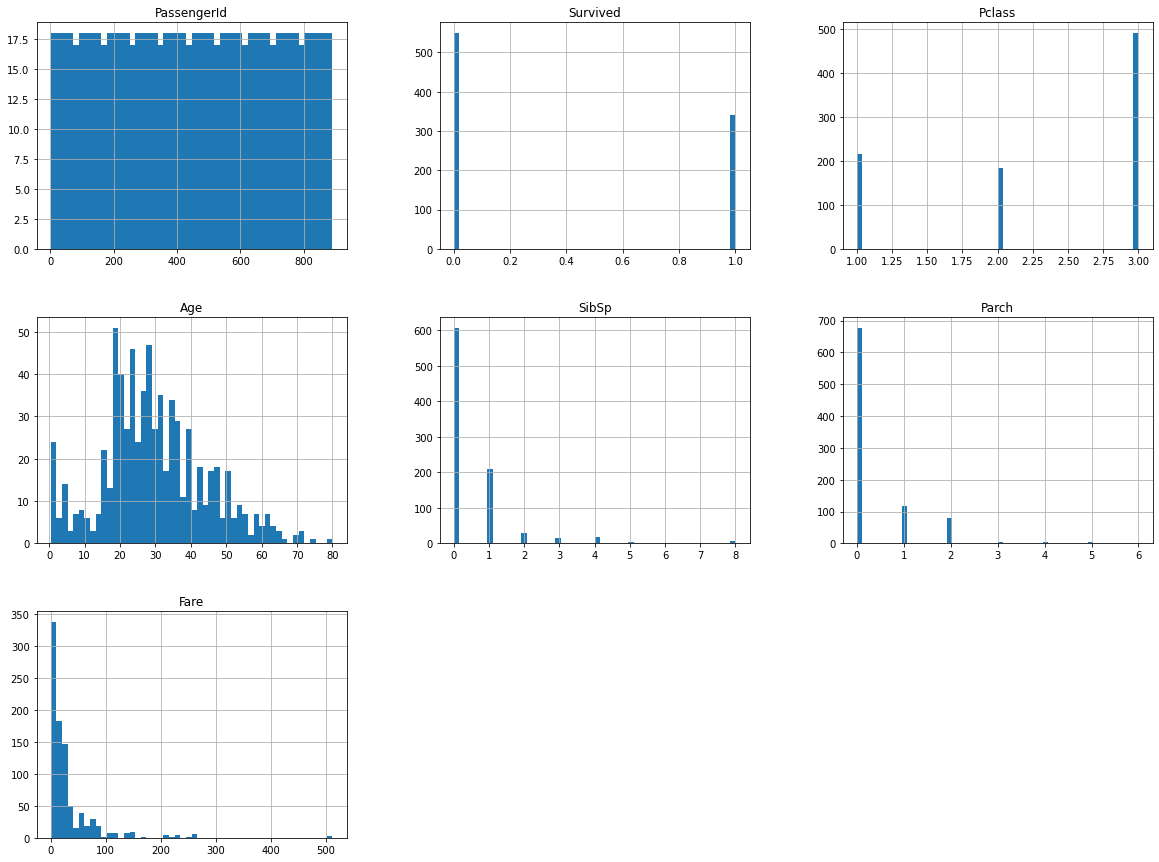

In [ ]:
df.hist(bins=50, figsize=(20,15));

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# Num unique values in each column
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [ ]:
# Alternative Seaborn corr matrix plot
# import seaborn as sns
# sns.heatmap(df.corr());

corr_mat = df.corr()
corr_mat['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [ ]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
display_missing(df)

PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2




# Do some feature engineering
Probably jumped into this too quickly.  Should I deal with missng values etc first?

## Add name title 
Extract substrings. Condense the list into a smaller subset of titles.
Maybe the person's title correlates with their survival rate.

In [ ]:
# Define a function to do string compare
import string
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        #print(substring, big_string)
        if big_string is np.nan:
            return np.nan
        if substring in big_string:
            return substring
    print(big_string)
    return np.nan

In [ ]:
# Iterate through the whole Name column, then try again adding any titles shown from the printed, unmatched names
titles = ['Mr.','Mrs.','Miss.','Master','Don.',
          'Rev.','Dr.','Mme.','Ms.','Major.',
          'Lady.','Sir.','Mlle.','Col','Capt.',
          'Countess.','Jonkheer.']

for thisName in df['Name']:
    substrings_in_string(thisName,titles)

In [ ]:
df['Title'] = df['Name'].map(lambda x: substrings_in_string(x, titles))
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


# Fill missing
How many values are missing from each column? Cabin, Age, Embarked all have missing data

In [ ]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

## Deal with Age nans first
Age correlates well with Pclass, then Sibsp.

In [ ]:
# Neat way to tabulate correlation against each parameter
# taken from https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial
# df_all_corr = df.corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
# df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
# df_all_corr[df_all_corr['Feature 1'] == 'Age']

# Less convoluted method of printing the correlation values against Age.
df.corr()['Age'].abs().sort_values(ascending=False)

Age            1.000000
Pclass         0.369226
SibSp          0.308247
Parch          0.189119
Fare           0.096067
Survived       0.077221
PassengerId    0.036847
Name: Age, dtype: float64

In [ ]:
df.groupby(['SibSp']).median()['Age']

SibSp
0    29.0
1    30.0
2    23.0
3     9.5
4     6.5
5    11.0
8     NaN
Name: Age, dtype: float64

In [ ]:
# Let's not ignore the categorical features Sex seems to also be correlated with age.
# Females are generally younger in this dataset.  
# All quartiles are lower in age, median is lower too.
a= df.groupby(['Sex'])
print(a.median()['Age'],'\n')
print(a.describe()['Age'])

Sex
female    27.0
male      29.0
Name: Age, dtype: float64 

        count       mean        std   min   25%   50%   75%   max
Sex                                                              
female  261.0  27.915709  14.110146  0.75  18.0  27.0  37.0  63.0
male    453.0  30.726645  14.678201  0.42  21.0  29.0  39.0  80.0


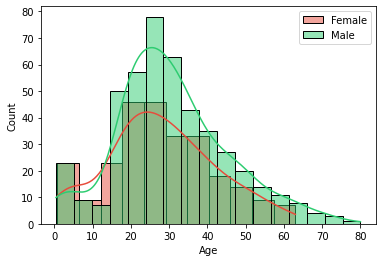

In [ ]:
# Hist of age groups for males/females
ax1 = plt.axes()
sns.histplot(df[df['Sex'] == 'female']['Age'], label='Female', color='#e74c3c', ax=ax1, kde=True)
sns.histplot(df[df['Sex'] == 'male']['Age'], label='Male', color='#2ecc71', ax=ax1, kde=True)
ax1.legend(loc='upper right', prop={'size': 10})
plt.show()

In [ ]:
# So let's pick both parameters and use to group the dataset,
# Then calc the median of each group, we'll use these for fillna()
df.groupby(['Sex', 'Pclass']).median()['Age']

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [ ]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

## Add a Deck number feature to assist with filling nans in Cabin feature
Extract it from the Cabin column. Maybe people certain decks were more likely to get into a lifeboat.

In [ ]:
decks = ['A','B','C','D','E','F','G','T']
for thisCabin in df['Cabin']:
#thisCabin = df['Cabin'][1]
    substrings_in_string(thisCabin,decks)

Sort decks by probability of survival.  Deck D, E, B all have close to 75% survival rates.

In [ ]:
# Group by Deck, print probability of survival for each
df['Deck'] = df['Cabin'].map(lambda x: substrings_in_string(x, decks))
# Replaced line by inserting 'M' for nan values
# df.groupby(['Deck'],dropna=False).mean()['Survived'].sort_values(ascending=False) 

df['Deck'] = df['Deck'].fillna('M')
df.groupby(['Deck']).mean()['Survived'].sort_values(ascending=False) 


Deck
E    0.757576
D    0.757576
B    0.744681
C    0.593220
F    0.583333
G    0.500000
A    0.466667
M    0.299854
T    0.000000
Name: Survived, dtype: float64

For interest, break this down by sex also.  So Sex is a great predictor of survival, especially coupled with Deck.

In [ ]:
df.groupby(['Sex','Deck']).mean()['Survived'].sort_values(ascending=False)

Sex     Deck
female  F       1.000000
        D       1.000000
        B       1.000000
        A       1.000000
        E       0.937500
        C       0.888889
        M       0.654378
male    E       0.588235
female  G       0.500000
male    D       0.466667
        A       0.428571
        B       0.400000
        F       0.375000
        C       0.343750
        M       0.136170
        T       0.000000
Name: Survived, dtype: float64

Now looking at how survival chance rises with ticket class.  1st Class has much higher chance of survival

In [ ]:
df.groupby(['Pclass'],dropna=False).mean()['Survived']

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Again Sex and Pclass here are great predictors, strong relationships are apparent in predicting survival rate.

In [ ]:
df.groupby(['Sex','Pclass'],dropna=False).mean()['Survived']

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64

For info. Only one guy was in deck T, didn't survive

In [ ]:
df[df['Deck'] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,Mr.,T


## Fix nan values in Embarked column

In [ ]:
df[df['Embarked'].isna() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss.,B
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs.,B


In [ ]:
# Guide I'm following googled the names and worked out they embarked from Southampton 'S'
# Fillna using this info
df['Embarked'] = df['Embarked'].fillna('S')

# Check nans left in dataset
df.isna().sum() # We're going to drop the Cabin column so it's ok if nonzero

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Title            0
Deck             0
dtype: int64

# Feature engineering
Add family size column

In [ ]:
df['familysize'] = df['Parch'] + df['SibSp'] + 1
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,familysize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,M,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,M,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.,M,1


Add an Age * class feature as a linear combination of the 2 features.  **Placeholder**

Add a "fare per person" feature, price of ticket divided by the family size **Placeholder**

Eventually wrap all this up into an sklearn pipeline.  But first draft up a prototype

# Binning continuous features

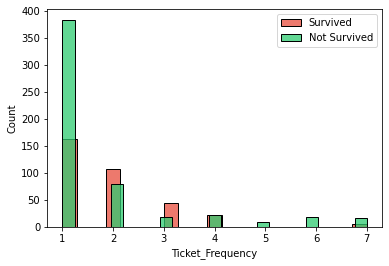

In [ ]:
# Add Ticket frequency feature as there's otherwise too many unique values in the 
# Ticket column.  Frequency should tell if more than one person travelled on the same
# ticket number, indicating they were in a group.  Similar to familysize feature we added
df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')
df.head()

# Plot hist
ax1 = plt.axes()
sns.histplot(df[df['Survived']==1]['Ticket_Frequency'], label='Survived', color='#e74c3c', ax=ax1)
sns.histplot(df[df['Survived']==0]['Ticket_Frequency'], label='Not Survived', color='#2ecc71', ax=ax1)
ax1.legend(loc='upper right', prop={'size': 10})
plt.show()

# Title

In [ ]:
# How many in each title category
df.groupby(['Title'])['Survived'].mean().sort_values(ascending=False)

Title
Sir.         1.000000
Lady.        1.000000
Ms.          1.000000
Countess.    1.000000
Mme.         1.000000
Mlle.        1.000000
Mrs.         0.792000
Miss.        0.697802
Master       0.575000
Major.       0.500000
Col          0.500000
Dr.          0.428571
Mr.          0.156673
Rev.         0.000000
Jonkheer.    0.000000
Don.         0.000000
Capt.        0.000000
Name: Survived, dtype: float64

# Start model build from scratch
Opportunity to remind myself the code and tidy up a bit

In [ ]:
 
import pandas as pd
import numpy as np
import os
 
df_train = pd.read_csv(os.path.join(path,'train.csv'))
df_test = pd.read_csv(os.path.join(path,'test.csv'))
 
# Save a number of rows to split by later, this just lets us do same preprocessing on both
rows_to_split = len(df_train)
 
df = df_train.append(df_test, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [ ]:
display_missing(df)

PassengerId column missing values: 0
Survived column missing values: 418
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 263
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 1014
Embarked column missing values: 2




In [ ]:
# Iterate through the whole Name column, then try again adding any titles shown from the printed, unmatched names
titles = ['Mr.','Mrs.','Miss.','Master','Don.','Dona.',
          'Rev.','Dr.','Mme.','Ms.','Major.',
          'Lady.','Sir.','Mlle.','Col','Capt.',
          'Countess.','Jonkheer.']

for thisName in df['Name']:
    substrings_in_string(thisName,titles)

In [ ]:
df['Title'] = df['Name'].map(lambda x: substrings_in_string(x, titles))
df.Title = df.Title.astype('category')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


## Fix missing Age

In [ ]:
# Less convoluted method of printing the correlation values against Age.
df.corr()['Age'].abs().sort_values(ascending=False)

Age            1.000000
Pclass         0.408106
SibSp          0.243699
Fare           0.178740
Parch          0.150917
Survived       0.077221
PassengerId    0.028814
Name: Age, dtype: float64

Age is correllated with SibSp

In [ ]:
# Median age for each category of sibsp
df.groupby(['SibSp']).median()['Age']

SibSp
0    28.0
1    30.0
2    21.5
3    14.5
4     7.0
5    10.5
8    14.5
Name: Age, dtype: float64

In [ ]:
# Let's not ignore the categorical features Sex seems to also be correlated with age.
# Females are generally younger in this dataset.  
# All quartiles are lower in age, median is lower too.
a= df.groupby(['Sex'])
print(a.describe()['Age'])

        count       mean        std   min   25%   50%   75%   max
Sex                                                              
female  388.0  28.687088  14.576962  0.17  19.0  27.0  38.0  76.0
male    658.0  30.585228  14.280581  0.33  21.0  28.0  39.0  80.0


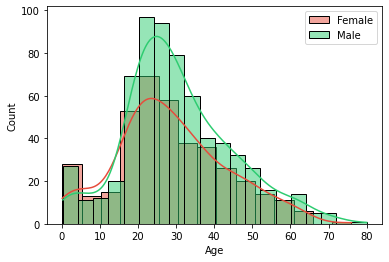

In [ ]:
# Hist of age groups for males/females
ax1 = plt.axes()
sns.histplot(df[df['Sex'] == 'female']['Age'], label='Female', color='#e74c3c', ax=ax1, kde=True)
sns.histplot(df[df['Sex'] == 'male']['Age'], label='Male', color='#2ecc71', ax=ax1, kde=True)
ax1.legend(loc='upper right', prop={'size': 10})
plt.show()

In [ ]:
# So let's pick both parameters and use to group the dataset,
# Then calc the median of each group, we'll use these for fillna()
df.groupby(['Sex', 'Pclass']).median()['Age']

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

In [ ]:
# Could've simply used the global median from the dataset, but the example I'm 
# following went a bit further than that.
# Apply a lambda function to each group.
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

# As a check, reprint the median of each group in the modified df, it shouldn't have changed.
df.groupby(['Sex', 'Pclass']).median()['Age']

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

Where are we at with missing values now

In [ ]:
display_missing(df)

PassengerId column missing values: 0
Survived column missing values: 418
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 0
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 1014
Embarked column missing values: 2
Title column missing values: 0




## Convert Cabin to Deck and fix missing
eck number feature to assist with filling nans in Cabin feature

Extract it from the Cabin column. Maybe people certain decks were more likely to get into a lifeboat.

In [ ]:
decks = ['A','B','C','D','E','F','G','T']
for thisCabin in df['Cabin']:
    substrings_in_string(thisCabin,decks)

Sort decks by probability of survival.  Deck D, E, B all have close to 75% survival rates.

In [ ]:
# Group by Deck, print probability of survival for each
df['Deck'] = df['Cabin'].map(lambda x: substrings_in_string(x, decks))
# Replaced line by inserting 'M' for nan values
# df.groupby(['Deck'],dropna=False).mean()['Survived'].sort_values(ascending=False) 

df['Deck'] = df['Deck'].fillna('M')
df.groupby(['Deck']).mean()['Survived'].sort_values(ascending=False) 


Deck
E    0.757576
D    0.757576
B    0.744681
C    0.593220
F    0.583333
G    0.500000
A    0.466667
M    0.299854
T    0.000000
Name: Survived, dtype: float64

### For interest
Break this down by sex also.  So Sex is a great predictor of survival, especially coupled with Deck.

In [ ]:
df.groupby(['Sex','Deck']).mean()['Survived'].sort_values(ascending=False)

Sex     Deck
female  F       1.000000
        D       1.000000
        B       1.000000
        A       1.000000
        E       0.937500
        C       0.888889
        M       0.654378
male    E       0.588235
female  G       0.500000
male    D       0.466667
        A       0.428571
        B       0.400000
        F       0.375000
        C       0.343750
        M       0.136170
        T       0.000000
Name: Survived, dtype: float64

Now looking at how survival chance rises with ticket class.  1st Class has much higher chance of survival

In [ ]:
df.groupby(['Pclass'],dropna=False).mean()['Survived']

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Again Sex and Pclass here are great predictors, strong relationships are apparent in predicting survival rate.

In [ ]:
df.groupby(['Sex','Pclass'],dropna=False).mean()['Survived']

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64

For info. Only one guy was in deck T, didn't survive

In [ ]:
df[df['Deck'] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
339,340,0.0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,Mr.,T


## Fix missing Embarked values

In [ ]:
df[df['Embarked'].isna() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss.,B
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs.,B


In [ ]:
# Guide I'm following googled the names and worked out they embarked from Southampton 'S'!
# Fillna using this info
df['Embarked'] = df['Embarked'].fillna('S')
 
# Check nans left in dataset
display_missing(df)

PassengerId column missing values: 0
Survived column missing values: 418
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 0
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 1014
Embarked column missing values: 0
Title column missing values: 0
Deck column missing values: 0




Missing values remain in Fare and Title.  Don't think these are worth worrying about.  Will drop these 2 rows.

## Model building

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
 
from sklearn.metrics import accuracy_score

In [ ]:
# Add new features and define pipeline
X_all = df[['Title','Deck','Fare','Sex']]
y_all = df['Survived']
 
y = y_all[:rows_to_split]
X = X_all[:rows_to_split]
y_subm = y_all[rows_to_split:]
X_subm = X_all[rows_to_split:]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
num_features = ['Fare']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])
 
cat_features = ['Title','Deck','Sex']
cat_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')
 
preprocessor = ColumnTransformer([('cats', cat_transformer, cat_features),
                                  ('nums', num_transformer, num_features)])
 
logreg_clf = Pipeline([('preprocessor', preprocessor),
                       ('model', LogisticRegression())])

In [ ]:
np.sum(np.isnan(preprocessor.fit_transform(X_train[['Fare','Title','Sex','Deck']])))

0

In [ ]:
X_train.Title

331      Mr.
733      Mr.
382      Mr.
704      Mr.
813    Miss.
       ...  
106    Miss.
270      Mr.
860      Mr.
435    Miss.
102      Mr.
Name: Title, Length: 712, dtype: category
Categories (18, object): ['Capt.', 'Col', 'Countess.', 'Don.', ..., 'Mrs.', 'Ms.', 'Rev.', 'Sir.']

In [ ]:
np.isnan(num_transformer.fit_transform(X_train[['Fare']])).sum()
X_train[['Fare']].isna().sum()

Fare    0
dtype: int64

In [ ]:
logreg_clf.fit(X_train,y_train);

In [ ]:
accuracy_score(y_train,logreg_clf.predict(X_train))

0.7963483146067416

In [ ]:
# CV over all labelled training data
cv_scores = cross_val_score(logreg_clf,X,y)
print(f'CV scores: {cv_scores}')
print(f'mean:  {cv_scores.mean():.3f}')
print(f'stdev: {cv_scores.std():.3f}')

CV scores: [0.77094972 0.78651685 0.76966292 0.75842697 0.79775281]
mean:  0.777
stdev: 0.014


In [ ]:
y_subm_pred = logreg_clf.predict(X_subm);
print(y_subm_pred.sum(), len(y_subm))

162.0 418


In [ ]:
# Compare to Dummy classifier
# Train a dummy classifier
from sklearn.dummy import DummyClassifier
 
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
 
dummy_score = accuracy_score(y_train,dummy_clf.predict(X_train[['Fare','Title','Sex','Deck']]))
print(f'Dummy/null accuracy: {dummy_score:.3f}')

Dummy/null accuracy: 0.624
